# Lesson 8: Object Detection

- In the classroom, the libraries are already installed for you.
- If you would like to run this code on your own machine, you can install the following:

```
    !pip install transformers
    !pip install gradio
    !pip install timm
    !pip install inflect
    !pip install phonemizer
```

**Note:**  `py-espeak-ng` is only available Linux operating systems.

To run locally in a Linux machine, follow these commands:
```
    sudo apt-get update
    sudo apt-get install espeak-ng
    pip install py-espeak-ng
```

### Build the `object-detection` pipeline using 🤗 Transformers Library

- This model was release with the paper [End-to-End Object Detection with Transformers](https://arxiv.org/abs/2005.12872) from Carion et al. (2020)

In [1]:
from helper import load_image_from_url, render_results_in_image

In [2]:
from transformers import pipeline

- Here is some code that suppresses warning messages.

In [3]:
from transformers.utils import logging

logging.set_verbosity_error()

from helper import ignore_warnings

ignore_warnings()

In [4]:
od_pipe = pipeline("object-detection", "facebook/detr-resnet-50")

/home/chenxin/anaconda3/envs/py310/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Info about [facebook/detr-resnet-50](https://huggingface.co/facebook/detr-resnet-50)

Explore more of the [Hugging Face Hub for more object detection models](https://huggingface.co/models?pipeline_tag=object-detection&sort=trending)

### Use the Pipeline

In [5]:
from PIL import Image

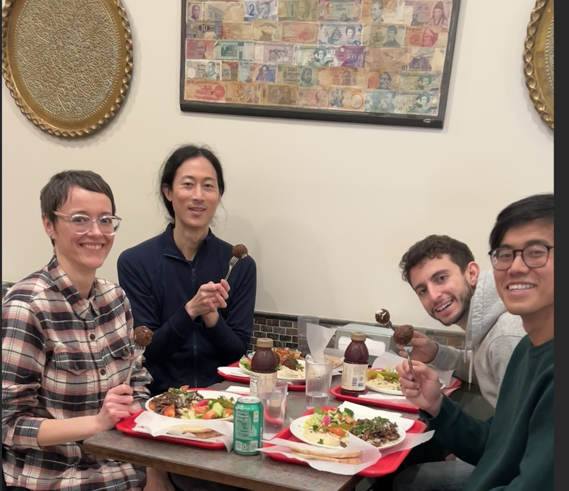

In [6]:
raw_image = Image.open("images/huggingface_friends.jpg")
raw_image.resize((569, 491))

In [7]:
pipeline_output = od_pipe(raw_image)

In [8]:
pipeline_output

[{'score': 0.985634982585907,
  'label': 'fork',
  'box': {'xmin': 808, 'ymin': 687, 'xmax': 836, 'ymax': 765}},
 {'score': 0.9912378191947937,
  'label': 'bottle',
  'box': {'xmin': 688, 'ymin': 667, 'xmax': 742, 'ymax': 789}},
 {'score': 0.9947125911712646,
  'label': 'cup',
  'box': {'xmin': 520, 'ymin': 769, 'xmax': 577, 'ymax': 863}},
 {'score': 0.9971532821655273,
  'label': 'person',
  'box': {'xmin': 779, 'ymin': 386, 'xmax': 1123, 'ymax': 972}},
 {'score': 0.9692015647888184,
  'label': 'bottle',
  'box': {'xmin': 465, 'ymin': 786, 'xmax': 527, 'ymax': 912}},
 {'score': 0.9346718788146973,
  'label': 'bowl',
  'box': {'xmin': 556, 'ymin': 739, 'xmax': 622, 'ymax': 779}},
 {'score': 0.9995748400688171,
  'label': 'person',
  'box': {'xmin': 231, 'ymin': 286, 'xmax': 510, 'ymax': 782}},
 {'score': 0.9991858601570129,
  'label': 'person',
  'box': {'xmin': 0, 'ymin': 338, 'xmax': 348, 'ymax': 974}},
 {'score': 0.974000871181488,
  'label': 'dining table',
  'box': {'xmin': 167, '

In [26]:
def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction["label"]
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are"
    for i, (label, count) in enumerate(summary.items()):
        result_string += f" {p.number_to_words(count)}"
        result_string += f" {p.plural(label, count)},"

        if i == len(summary) - 2:
            result_string += " and"

    # Remove the trailing comma and space
    result_string = result_string.rstrip(", ") + "."

    return result_string

In [27]:
summarize_predictions_natural_language(pipeline_output)

'In this image, there are two forks, three bottles, two cups, four people, one bowl, and one dining table.'

- Return the results from the pipeline using the helper function `render_results_in_image`.

In [13]:
import io
import matplotlib.pyplot as plt
import requests
import inflect
from PIL import Image


def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16, 10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:
        x, y = prediction["box"]["xmin"], prediction["box"]["ymin"]
        w = prediction["box"]["xmax"] - prediction["box"]["xmin"]
        h = prediction["box"]["ymax"] - prediction["box"]["ymin"]

        ax.add_patch(
            plt.Rectangle((x, y), w, h, fill=False, color="green", linewidth=2)
        )
        ax.text(
            x,
            y,
            f"{prediction['label']}: {round(prediction['score']*100, 1)}%",
            color="red",
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format="jpeg", bbox_inches="tight", pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)
    # modified_image = modified_image.convert('RGB')  # Convert to 'RGB' to avoid errors when saving as JPEG or displaying

    # Close the plot to prevent it from being displayed
    plt.close()

    return modified_image

In [14]:
processed_image = render_results_in_image(raw_image, pipeline_output)

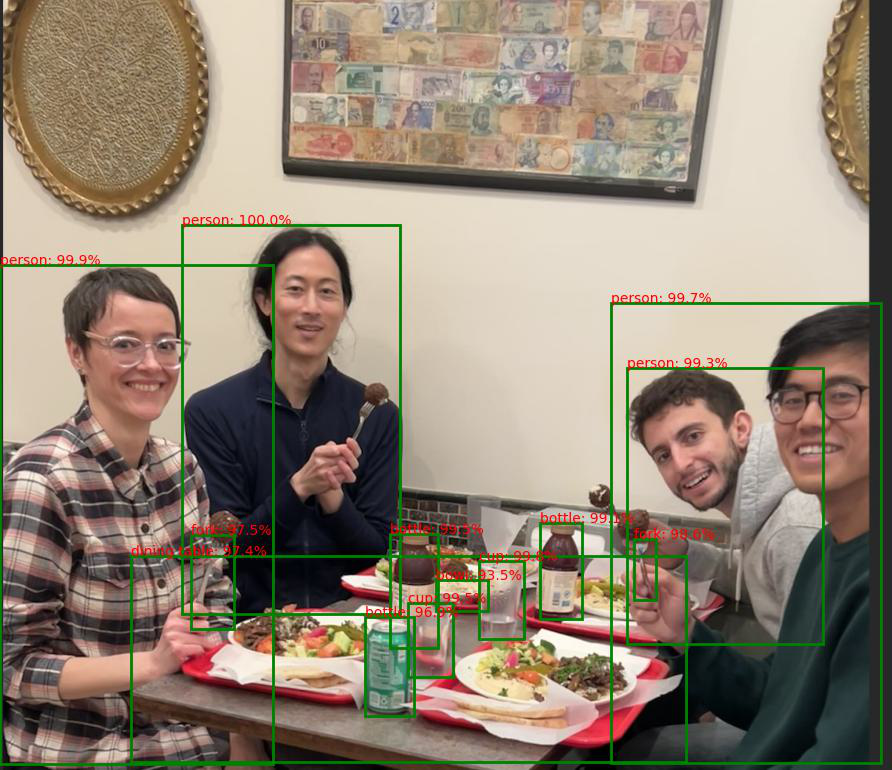

In [15]:
processed_image

### Using `Gradio` as a Simple Interface

- Use [Gradio](https://www.gradio.app) to create a demo for the object detection app.
- The demo makes it look friendly and easy to use.
- You can share the demo with your friends and colleagues as well.

In [16]:
import os
import gradio as gr

In [17]:
def get_pipeline_prediction(pil_image):

    pipeline_output = od_pipe(pil_image)

    processed_image = render_results_in_image(pil_image, pipeline_output)
    return processed_image

In [18]:
demo = gr.Interface(
    fn=get_pipeline_prediction,
    inputs=gr.Image(label="Input image", type="pil"),
    outputs=gr.Image(label="Output image with predicted instances", type="pil"),
)

- `share=True` will provide an online link to access to the demo

In [20]:
demo.launch(share=True, server_port=7860)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://f11a084458dc76055e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [28]:
demo.close()

Closing server running on port: 7860


### Close the app
- Remember to call `.close()` on the Gradio app when you're done using it.

### Make an AI Powered Audio Assistant

- Combine the object detector with a text-to-speech model that will help dictate what is inside the image.

- Inspect the output of the object detection pipeline.

In [15]:
pipeline_output

[{'score': 0.9856818318367004,
  'label': 'fork',
  'box': {'xmin': 808, 'ymin': 688, 'xmax': 836, 'ymax': 765}},
 {'score': 0.9904232025146484,
  'label': 'bottle',
  'box': {'xmin': 688, 'ymin': 667, 'xmax': 743, 'ymax': 789}},
 {'score': 0.9948464632034302,
  'label': 'cup',
  'box': {'xmin': 520, 'ymin': 770, 'xmax': 577, 'ymax': 863}},
 {'score': 0.9971936941146851,
  'label': 'person',
  'box': {'xmin': 778, 'ymin': 387, 'xmax': 1125, 'ymax': 972}},
 {'score': 0.9695369005203247,
  'label': 'bottle',
  'box': {'xmin': 465, 'ymin': 786, 'xmax': 527, 'ymax': 912}},
 {'score': 0.9300816059112549,
  'label': 'bowl',
  'box': {'xmin': 556, 'ymin': 739, 'xmax': 622, 'ymax': 779}},
 {'score': 0.9995697140693665,
  'label': 'person',
  'box': {'xmin': 231, 'ymin': 286, 'xmax': 510, 'ymax': 783}},
 {'score': 0.9992026686668396,
  'label': 'person',
  'box': {'xmin': 0, 'ymin': 338, 'xmax': 349, 'ymax': 974}},
 {'score': 0.9742276668548584,
  'label': 'dining table',
  'box': {'xmin': 167,

In [16]:
od_pipe

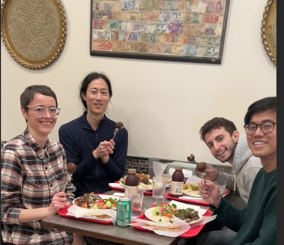

In [17]:
raw_image = Image.open("huggingface_friends.jpg")
raw_image.resize((284, 245))

In [18]:
from helper import summarize_predictions_natural_language

In [19]:
text = summarize_predictions_natural_language(pipeline_output)

In [20]:
text

'In this image, there are two forks three bottles two cups four persons one bowl and one dining table.'

### Generate Audio Narration of an Image

In [21]:
tts_pipe = pipeline("text-to-speech", model="./models/kakao-enterprise/vits-ljs")

More info about [kakao-enterprise/vits-ljs](https://huggingface.co/kakao-enterprise/vits-ljs).

In [22]:
narrated_text = tts_pipe(text)

### Play the Generated Audio

In [23]:
from IPython.display import Audio as IPythonAudio

In [24]:
IPythonAudio(narrated_text["audio"][0], rate=narrated_text["sampling_rate"])

### Try it yourself! 
- Try these models with other images!